In [198]:
import sympy as sm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math as m
import bisect

sp.__version__

'1.10.1'

https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.make_interp_spline.html#scipy.interpolate.make_interp_spline

#### Лаба 1
#### Алгоритмы планирования траекторий

1. Генерация $\mathcal{C}^0$ гладкой траектории через 10 точек. 
2. Генерация $\mathcal{C}^1$ гладкой траектории
3. Генерация $\mathcal{C}^2$ гладкой траектории

#### Вариант 5

In [199]:
# Координаты точек:
gx = np.float32(np.array([15,5,7,9,18,13,2,-2,1,3]))
gy = np.float32(np.array([ 6,4,15,8,11,17,23,19,1,13]))
# coordinates = {'x':np.array(x), 'y':np.array(y)}

In [200]:
class PathPlanning2D:
    def __init__(self, x, y, curvature="C0", Rmax = 0.25):
        self.s = []
        self.l = [] # lengths of segments
        self.p_I = np.array([x, y])
        self.p_P = []
        self.R = []
        self.phi = []
        self.nx = np.size(x,0)
        self.curvature = curvature
        self.spline_C0(x,y)

        self.Rmax = Rmax
        if curvature=="C1":
            self.p_c0 = np.array([]).reshape(2,0)
            self.s_Q = np.array([])
            self.sigma = np.array([])
            # self.p_Q = Q1 = [0,l1-Rctg(sigma)], Q2 = [R(1+cos(gamma)),l1-R(ctg(sigma)-sin(gamma))]
            self.spline_C1()
    
    def spline_C1(self):
        for i in np.arange(self.nx-2):
            if self.p_P[i][0][2] < 0: 
            # если второй отрезок этих трех точек повернут влево,
            # то необходимо отразить его, чтобы он был справа от оси ординат, затем необходимо повернуть обратно **********
                delta = np.arctan((self.p_P[i][1][2]-self.p_P[i][1][1])/(-self.p_P[i][0][2]+self.p_P[i][0][1]))
            else:
                delta = np.arctan((self.p_P[i][1][2]-self.p_P[i][1][1])/(self.p_P[i][0][2]-self.p_P[i][0][1]))
            if self.phi[i] > self.phi[i+1]:
                self.sigma = np.append( self.sigma, m.pi/4+delta/2 )
            else:
                self.sigma = np.append( self.sigma, m.pi/4+delta/2 )
            self.s_Q = np.append(self.s_Q, self.s[i+1]-self.Rmax/np.tan(self.sigma[i]) )
            self.s_Q = np.append(self.s_Q, self.s[i+1]+self.Rmax/np.tan(self.sigma[i]) )
            
            p_c0 = np.array([self.Rmax,self.l[i]-self.Rmax/np.tan(self.sigma[i])]).reshape(2,1)
            if self.p_P[i][0][2] < 0: # поворот обратно                                                        ************
                p_c0[0] = -p_c0[0]
            self.p_c0 = np.hstack(( self.p_c0, self.p_I.T[i].reshape(2,1) +\
                                    np.dot( np.transpose(self.R[i]), p_c0 ) ))

    def spline_C0(self,x,y):
        self.phi = self.__calc_phi(x,y) # угловая ориентация первого участка пути
        
        for i in np.arange(self.nx-1):
            self.R.append( np.array( [[np.cos(self.phi[i]),np.sin(self.phi[i])],
                                      [-np.sin(self.phi[i]),np.cos(self.phi[i])]] ) )
            
            if not i==(self.nx-2):
                p_P = np.array([]).reshape(2,0)
                for j in np.arange(3): # 3 
                    p_P = np.hstack((p_P,  np.dot( self.R[i], ( self.p_I.T[j+i].reshape(2,1) -\
                                self.p_I.T[i].reshape(2,1) ) ) ) ) 
                self.p_P.append(p_P)
            else:
                p_P = np.array([]).reshape(2,0)
                for j in np.arange(2): # 3 
                    p_P = np.hstack((p_P,  np.dot( self.R[i], ( self.p_I.T[j+i].reshape(2,1) -\
                                self.p_I.T[i].reshape(2,1) ) ) ) ) 
                self.p_P.append(p_P)
        
        self.__calc_s() # point's positions in S^0 curve

    def calc_curvature(self, s):
        i = self.__search_index(s)
        if self.curvature == "C0":
            k = 0
            # phi = self.phi[i] + m.pi/2
            # if phi>m.pi/2 and phi<-m.pi/2:
            #     k = -np.tan(phi)
            # else:
            #     k = np.tan(phi)
        elif self.curvature == "C1":
            if i==self.nx-1:
                i-=1
            section_type = 0
            if i==0:
                if s > self.s_Q[0]:
                    section_type = 1
            else:
                left_switch = self.s_Q[i*2-1] # левый переключатель на этом сегменте
                if i==self.nx-2: # last segment number, there is no right switcher
                    right_switch = self.s[self.nx-1] # правый переключатель на этом сегменте
                else:
                    right_switch = self.s_Q[i*2] # правый переключатель на этом сегменте
                if s > right_switch:
                    section_type = 1
                elif s < left_switch:
                    section_type = 1
            if section_type:
                k = 1/self.Rmax
            else:
                k = 0
        return k

    def calc_position(self, s):
        if s < self.s[0]:
            return None
        elif s > self.s[-1]:
            return None
        i = self.__search_index(s)
        ds = s - self.s[i]
        if self.curvature == "C0":
            p_start = self.p_I.T[i].reshape(2,1) 
            if i==len(self.s)-1:
                p = p_start
            else:
                p = p_start + np.dot( np.transpose(self.R[i]), np.array([0,ds]).reshape(2,1) )
        if self.curvature == "C1":
            p_start = self.p_I.T[i].reshape(2,1) 
            if i==len(self.s)-1:
                p = p_start
            else:
                section_type = 0 # 0 - line, 1 - circle
                circle_number = 0 # number of circle, 0,...,nx-2
                # print(i)
                if i==0:
                    if s > self.s_Q[0]:
                        section_type = 1
                        circle_number = 0
                else:
                    # print(i)
                    left_switch = self.s_Q[i*2-1] # левый переключатель на этом сегменте
                    if i==self.nx-2: # last segment number, there is no right switcher
                        right_switch = self.s[self.nx-1] # правый переключатель на этом сегменте
                    else:
                        right_switch = self.s_Q[i*2] # правый переключатель на этом сегменте
                    if s > right_switch:
                        section_type = 1
                        circle_number = i
                    elif s < left_switch:
                        section_type = 1
                        circle_number = i-1
                # print(section_type)
                # print(circle_number)

                if section_type:
                    beta = m.pi - 2*self.sigma[circle_number]
                    # print(beta)
                    first_switch_num = 2*circle_number # индекс левого переключателя на этой окружности
                    # print(first_switch_num)
                    alpha = beta*((ds+self.s[i])-self.s_Q[first_switch_num])/(self.s_Q[first_switch_num+1]-self.s_Q[first_switch_num])
                    d = 2*self.Rmax*np.sin(alpha/2)
                    # print(d)
                    gamma = (m.pi-alpha)/2
                    p_P = np.array([d*np.cos(gamma),
                                    (self.s_Q[first_switch_num]-self.s[circle_number])+d*np.sin(gamma)]).reshape(2,1)
                    # print(circle_number)
                    # print(p_P)
                    if self.p_P[circle_number][0][2] < 0: 
                        p_P[0]=-p_P[0] # если второй отрезок этих трех точек повернут влево,
                        # то необходимо отразить точки окружности, чтобы она была слева от оси ординат
                    p = self.p_I.T[circle_number].reshape(2,1) + np.dot( np.transpose(self.R[circle_number]), p_P )                    
                else:
                    p = p_start + np.dot( np.transpose(self.R[i]), np.array([0,ds]).reshape(2,1) )
        return p[0][0],p[1][0]

    def __search_index(self, x):
        return bisect.bisect(self.s, x) - 1

    def __calc_s(self):
        s = [0]
        for i in np.arange(len(self.p_P)):
            s = np.append(s,self.p_P[i][1][1])
        self.l = s[1:]
        self.s = np.cumsum(s)

    def __calc_phi(self,x,y):
        phi = []
        for i in np.arange(self.nx-1):
            phi = np.append(phi,np.arctan2(y[i+1]-y[i],x[i+1]-x[i]))
            if phi[i] < 0:
                phi[i] = 2*m.pi + phi[i]
            phi[i] = (phi[i] - m.pi/2)
        return phi
    


In [205]:
ds = 0.05  # [m] distance of each interpolated points
Rmax=2
pplan = []
pplan.append( PathPlanning2D(gx,gy,"C0",Rmax) )
pplan.append( PathPlanning2D(gx,gy,"C1",Rmax) )

data_rx = []
data_ry = []
data_rk = []

# i = 0 - C0, 1 - C1, 2 - C2
for i in range(2):
    s = np.arange(0, pplan[i].s[-1], ds)
    s = np.append(s, pplan[i].s[-1])
    rx, ry, rk = [], [], []
    for i_s in s:
        ix, iy = pplan[i].calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        rk.append(pplan[i].calc_curvature(i_s))

    data_rx.append(rx)
    data_ry.append(ry)
    data_rk.append(rk)

Text(0, 0.5, 'Curvature $|\\xi|,[1/m]$')

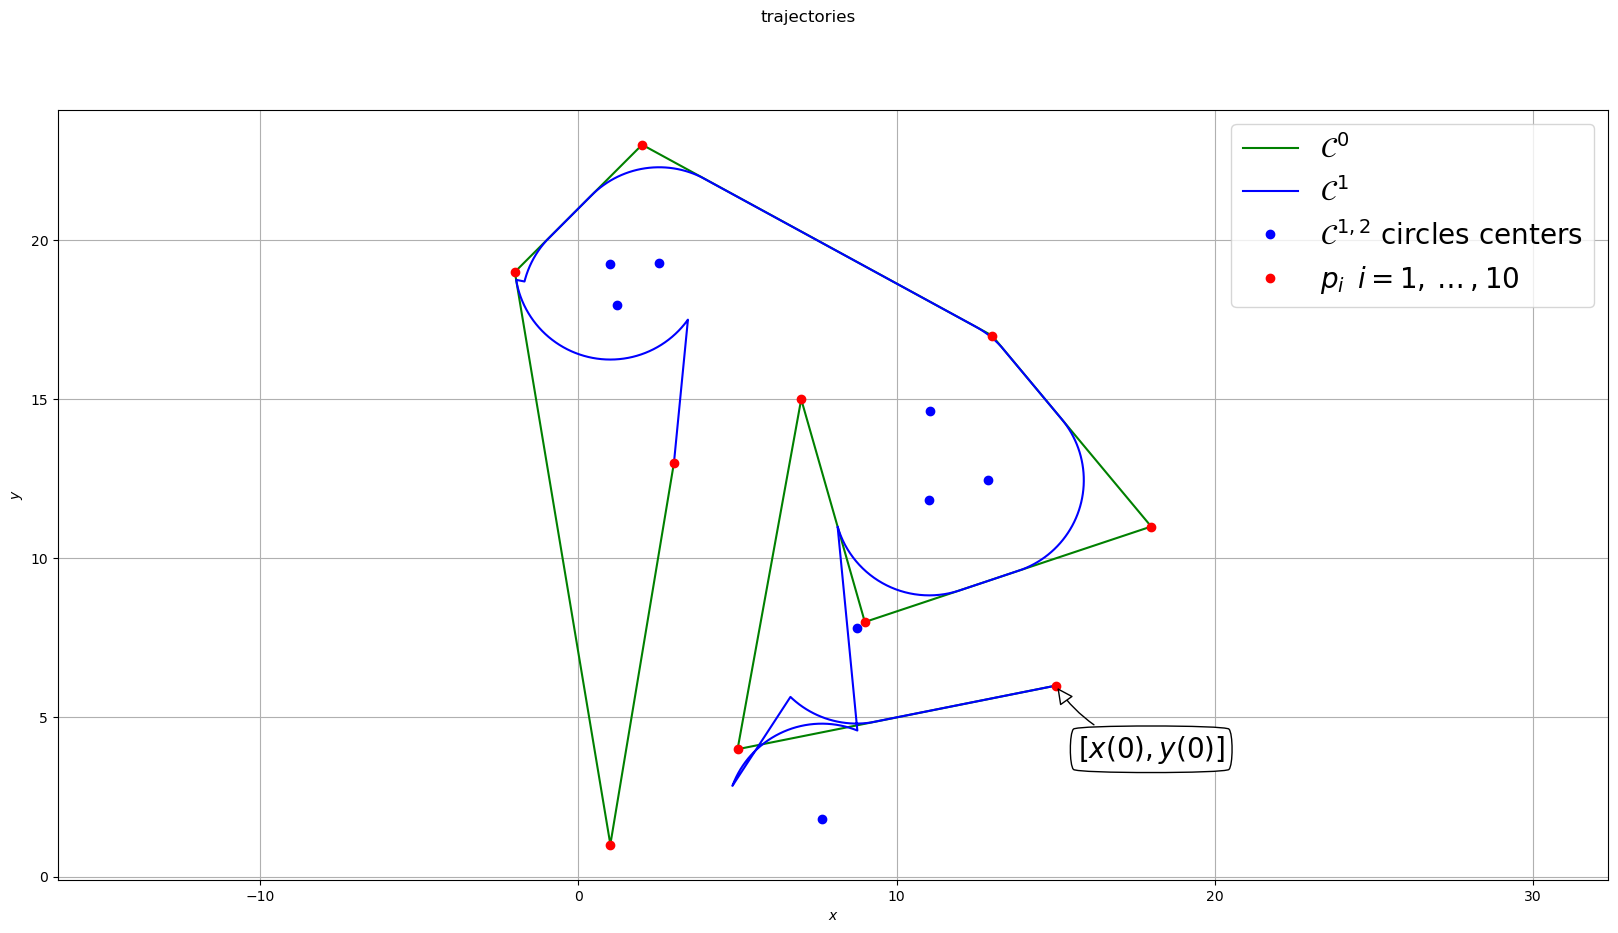

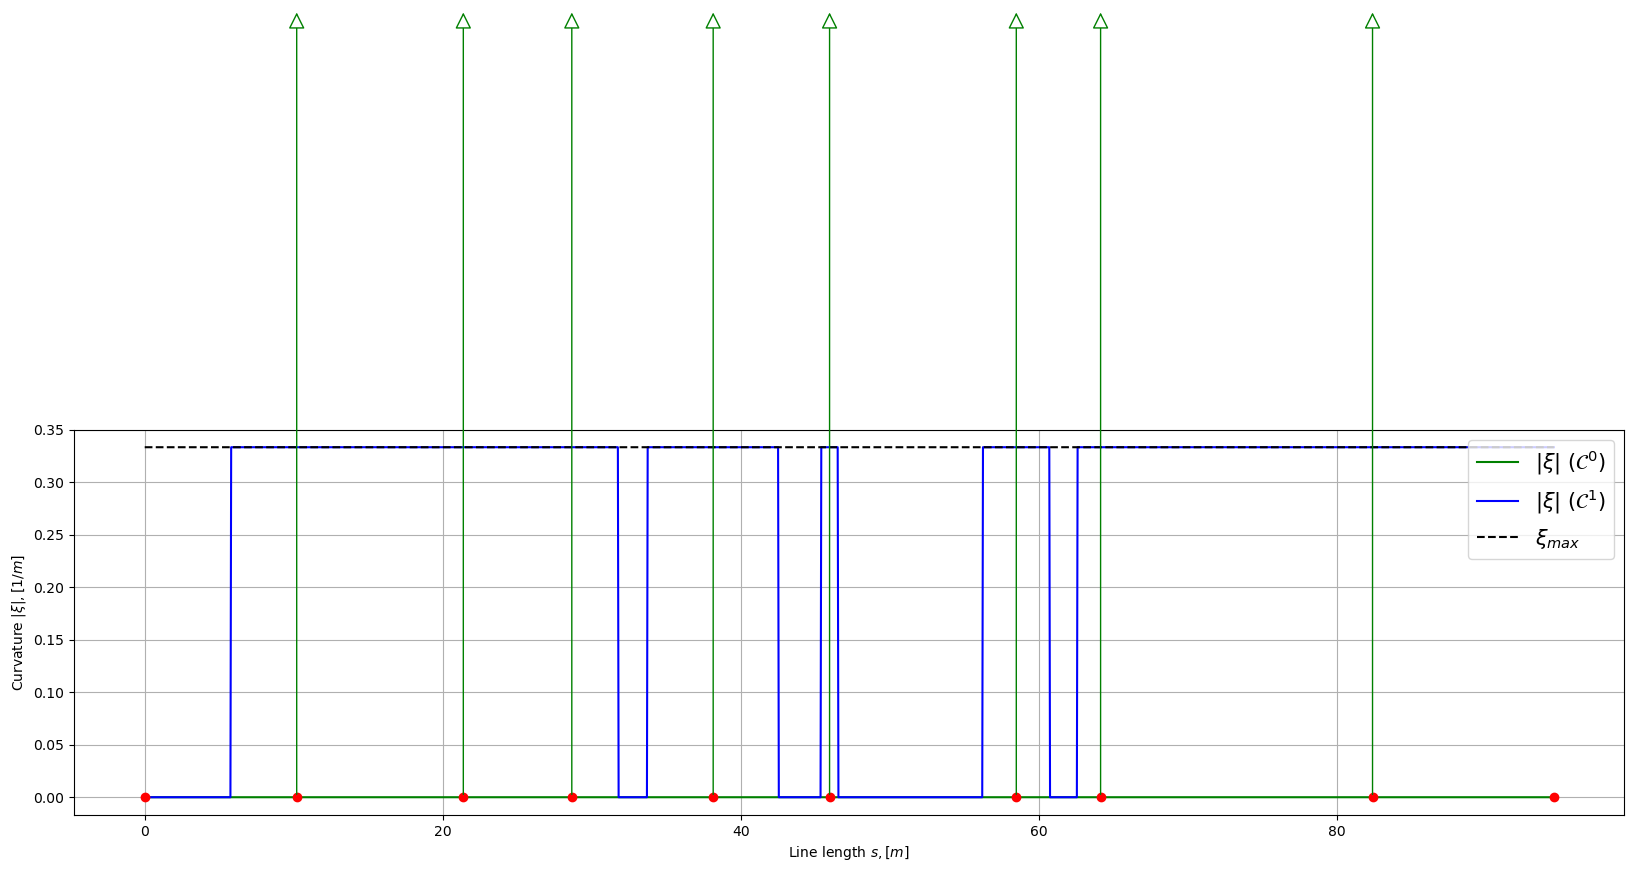

In [206]:
fig, ax = plt.subplots(1,1,figsize = (20,10))
ax = [ax, 1]
labels = ['$\mathcal{C}^0$','$\mathcal{C}^1$']
colours = ['g','b']
for i in range(2):
    ax[0].plot(data_rx[i][:], data_ry[i][:],"-",label=labels[i],color=colours[i])

ax[0].plot(pplan[1].p_c0[0],pplan[1].p_c0[1],'ob',label='$\mathcal{C}^{1,2}$ circles centers')
ax[0].plot(gx, gy, "or", label='$p_{i}\,\,\,i=1,\dots,10$')

ax[0].annotate(rf'$[x(0),y(0)]$',
                  xy=(gx[0],gy[0]),
                  xytext=(gx[0]+3,gy[0]-2),
                  size=20, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w"),
                  arrowprops=dict(arrowstyle="-|>",mutation_scale=25,
                                  connectionstyle="arc3,rad=-0.2", fc="w"))
fig.suptitle("trajectories")
ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$y$")
ax[0].grid(True)
ax[0].legend(fontsize="20",loc='upper right')
ax[0].axis('equal')

plt.subplots(1,1,figsize = (20,5))
labels = ['$|\\xi|$ ($\mathcal{C}^0$)','$|\\xi|$ ($\mathcal{C}^1$)']
colours = ['g','b']
for i in range(2):
    plt.plot(s, data_rk[i], "-",label=labels[i],color=colours[i])
plt.plot(pplan[0].s, np.zeros(len(pplan[0].s)), "or") # точки поворотов
for x,y,xnew,ynew in zip(pplan[0].s[1:-1],np.zeros(len(pplan[0].s[1:-1])), pplan[0].s[1:-1],
                         pplan[0].Rmax*0.25*np.ones(len(pplan[0].s[1:-1]))):
    plt.annotate("", xy=(x, y), xytext=(xnew,ynew),size=15, va="center", ha="center",
        arrowprops=dict(arrowstyle="<|-",mutation_scale=25,fc="w",color='green'))
    plt.annotate("$\infty$", xy=(xnew, ynew+ynew*0.05),size=20, va="center", ha="center",color='green')

k_max, = plt.plot(s, [1/Rmax]*len(s), "--k",label='$\\xi_{max}$')
plt.grid(True)
plt.legend(fontsize="15",loc='upper right')
plt.xlabel("Line length $s,[m]$")
plt.ylabel("Curvature $|\\xi|,[1/m]$")